This project aims to explore the distribution of selected keywords in historical corpuses to provide insights in terms of their temporal dynamic with respect to their contextual meaning.
Consider the popular Harry potter movie whose dataset is available in Harry Potter Dataset | Kaggle, indicating the content of the three movie distinguishing the script of each character of the movies. You may also find in Kaggle some code for data handling and visualization.


# Part 1
### 1. Write a script that calculates the length of total script of each character and draws the histogram showing the length of script of each character.

            Character  Script Length
0               Harry          26685
1            Hermione          14317
2                 Ron          14135
3              Hagrid          13511
4          Dumbledore          11489
5               Lupin           7613
6          Mcgonagall           6906
7               Snape           5481
8   Gilderoy Lockhart           4111
9          Tom Riddle           3390
10              Draco           3102
11      Lucius Malfoy           2553
12              Dobby           2523
13             Sirius           2490
14              Fudge           2309
15       Mrs. Weasley           2144
16       Uncle Vernon           1892
17          Trelawney           1513
18              Filch           1439
19            Petunia           1413


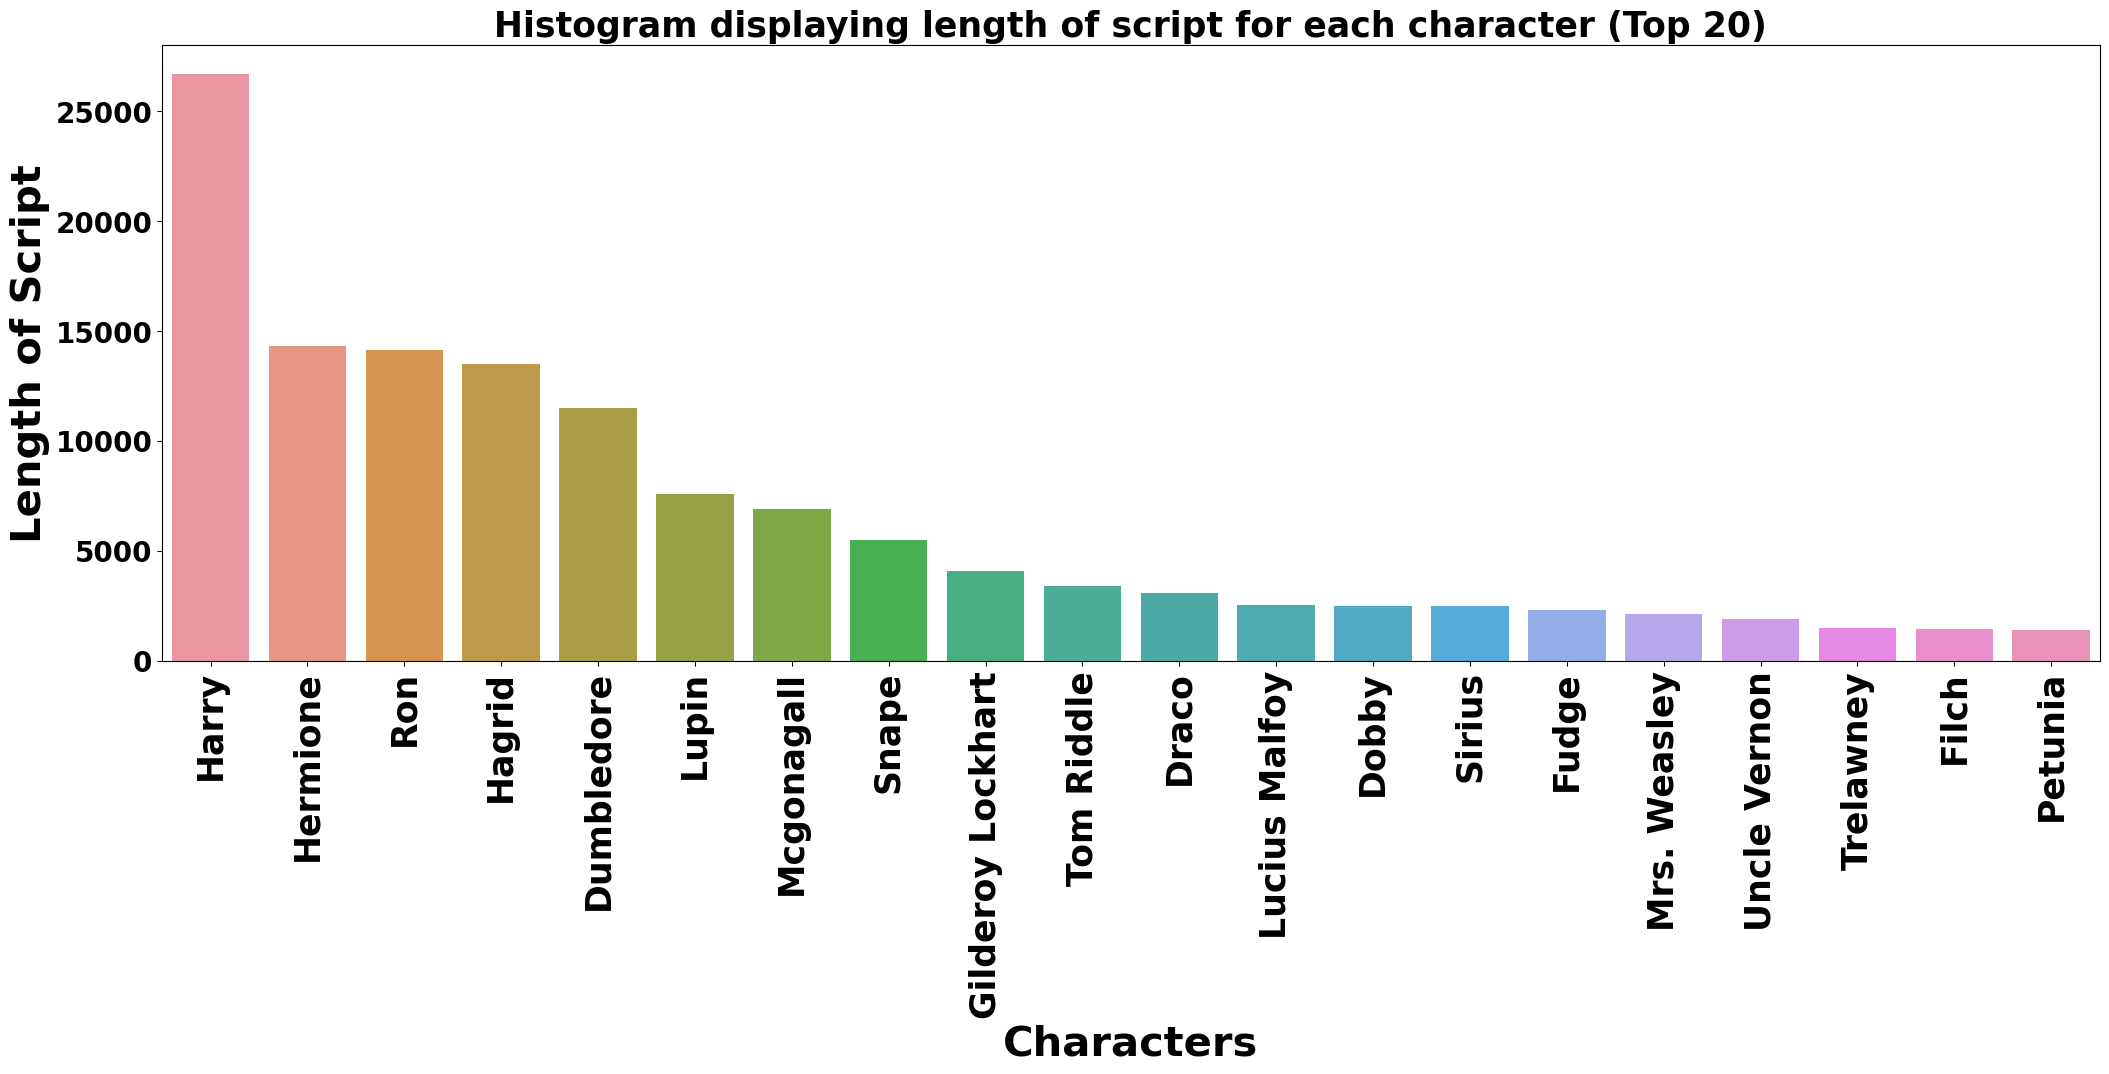

In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import pandas as pd
from collections import Counter

pd.set_option('display.max_columns', None)

files = ["Harry_Potter_1.csv","Harry_Potter_2.csv","Harry_Potter_3.csv"]

li = []

for filename in files:
    df = pd.read_csv(filename, sep = ";")
    df.columns = df.columns.str.title()
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df["Character"] = df["Character"].apply(lambda x: x.strip().title()) 
df["Script Length"] = df["Sentence"].apply(lambda x: len(x))

# Group the data by character name and calculate the total length of script for each character
characters = df.groupby("Character",sort=True).sum().sort_values(["Script Length"],ascending=False).reset_index()
no_of_characters = 20
characters = characters.iloc[:no_of_characters,:]
print(characters)

# Plot the histogram of script lengths
plt.figure(figsize=(25,8))
sns.barplot(x = characters["Character"],y=characters["Script Length"])
plt.ylabel("Length of Script",fontsize=30, weight='bold')
plt.xlabel("Characters",fontsize=30, weight='bold')
plt.xticks(rotation = 90, fontsize=25,weight='bold')
plt.yticks(fontsize=20, weight='bold')
plt.title("Histogram displaying length of script for each character (Top {})".format(no_of_characters),fontsize=25, weight='bold')
plt.show()

In [ ]:
len(df["Character"].unique())

In [ ]:
explaining y axis a bit more

# Part 2
### 2.	Consider the list of personal pronouns and Bing Liu opinion sentiment available at http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html. Write a script that counts the total number of personal pronouns in each characters’s scripts, and draw histogram. Repeat this process for both positive and negative sentiment word according to Bing Liu lexicon, and draw the corresponding histogram.

In [ ]:
# Load the list of personal pronouns
pronouns = ['i', 'me', 'my', 'mine', 'myself',
            'you', 'your', 'yours', 'yourself',
            'he', 'him', 'his', 'himself',
            'she', 'her', 'hers', 'herself',
            'it', 'its', 'itself',
            'we', 'us', 'our', 'ours', 'ourselves',
            'they', 'them', 'their', 'theirs', 'themselves']

# Load the list of positive and negative sentiment words
positive_words = []
negative_words = []

with open("Bing.csv") as f:
        lines = f.readlines()
for line in lines:
    word = line.split(",")[0]
    if line.split(",")[1].strip() == "positive":
        positive_words.append(word)
    else:
        negative_words.append(word)
print("######################## Done ###########################")

# Count the number of personal pronouns in each character's scripts
pronoun_counts = {}

for character in df["Character"].unique():
    
    character_scripts = df[df["Character"] == character]["Sentence"]
    count = 0
    for script in character_scripts:
        count += len([word for word in script.lower().split() if word in pronouns])
    pronoun_counts[character] = count

pronoun_counts = dict(sorted(pronoun_counts.items(), key=lambda item: item[1],reverse=True))
no_of_characters = 30
# Plot the histogram of personal pronoun counts
plt.figure(figsize=(12,6))
sns.barplot(x = list(pronoun_counts.values())[:no_of_characters], y = list(pronoun_counts.keys())[:no_of_characters],orient='h')
plt.ylabel("Character",weight='bold')
plt.xlabel("Number of Personal Pronouns",weight='bold')
plt.title("Personal Pronoun Count for Top {} Characters".format(no_of_characters))
plt.show()

# Count the number of positive and negative sentiment words in each character's scripts
positive_counts = {}
negative_counts = {}
for character in df["Character"].unique():
    character_scripts = df[df["Character"] == character]["Sentence"]
    positive_count = 0
    negative_count = 0
    for script in character_scripts:
        positive_count += len([word for word in script.lower().split() if word in positive_words])
        negative_count += len([word for word in script.lower().split() if word in negative_words])
    positive_counts[character] = positive_count
    negative_counts[character] = negative_count

# Plot the histograms of positive and negative sentiment word counts

positive_counts = dict(sorted(positive_counts.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(12,6))
sns.barplot(x = list(positive_counts.values())[:no_of_characters], y = list(positive_counts.keys())[:no_of_characters],orient='h')
plt.ylabel("Character",weight='bold')
plt.xlabel("Number of Positive Sentiment Words",weight='bold')
plt.title("Positive Sentiment Word Count for Top {} Characters".format(no_of_characters))
plt.show()

negative_counts = dict(sorted(negative_counts.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(12,6))
sns.barplot(x = list(negative_counts.values())[:no_of_characters], y = list(negative_counts.keys())[:no_of_characters], orient='h')
plt.ylabel("Character",weight='bold')
plt.xlabel("Number of Negative Sentiment Words",weight='bold')
plt.title("Negative Sentiment Word Counts for Each Character")
plt.show()

In [ ]:
plotting all graphs vertically(showing highest pos and neg sentiments)

# Part 3
Consider the corpus of each character (concatenation of all scripts of each character). Perform the LDA for topic modelling with Number of Topics = 5 and Number of Keywords per Topic = 5. Visualize the outcomes of the topic modelling according to the method of your choice in such a way to seek the overlapping among the various characters.

In [2]:
# Define a function to preprocess the text
def preprocess(text):
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Concatenate the scripts for each character
characters = df["Character"].unique().tolist()
corpus = {}

for character in tqdm(characters):
    flat_list = []
    l = df[df["Character"] == character]["Sentence"].apply(preprocess).tolist()
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    corpus[character] = flat_list

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:05<00:00, 19.33it/s]


In [ ]:
dictionary = corpora.Dictionary([corpus[character] for character in characters])

# Create a bag-of-words representation of the corpus
#bow_corpus = [dictionary.doc2bow(corpus[character]) for character in characters]
bow_corpus = {character: [dictionary.doc2bow(corpus[character])] for character in characters}
# Train the LDA model
num_topics = 5
num_keywords = 5

lda_models = {}

for name in tqdm(characters):
    lda_model = models.LdaModel(bow_corpus[name], id2word=dictionary, num_topics=num_topics, passes=10, alpha='auto', eta='auto')
    lda_models[name] = lda_model
    

In [ ]:
character_topics = {}

for char_name, lda_model in tqdm(lda_models.items()):
    for char_name1, lda_model1 in lda_models.items():
        if char_name != char_name1:
            topics = []
            overlapping = []
            for topic_num in range(num_topics):
                top_keywords = [word for word, _ in lda_model.show_topic(topic_num, topn=20)]
                top_keywords1 = [word for word, _ in lda_model1.show_topic(topic_num, topn=20)]
                a_set = set(top_keywords)
                b_set = set(top_keywords1)

                print("----- Topic {} -----".format(topic_num))
                print("Total Number of Common Words between {} & {} characters = {}".format(char_name,char_name1,len(list(a_set.intersection(b_set)))))
                print("######## Common Words ######## \n{}".format(a_set.intersection(b_set)))
                
                num = len(list(a_set.intersection(b_set)))
                den = len(list(a_set) + list(b_set))
                over = (num / den)*100
                print("Overlapping Percentage = {}".format(over))
                print("#####################################################")
                print("")
                topics.append(str(topic_num))
                overlapping.append(over)
                
            plt.figure(figsize=(6,3))
            
            df = pd.DataFrame({"Topic":topics,"Overlapping":overlapping})
            
            sns.barplot(data = df,y="Overlapping",x="Topic",)
            plt.xlabel("Topic Number")
            plt.ylabel("% Overlap b/w {} & {}".format(char_name,char_name1),fontsize=8)
            plt.show()
            

#overlapping_keywords = set.intersection(*[set(topic) for topics in character_topics.values() for topic in topics])
#print("Overlapping keywords:", overlapping_keywords)

In [ ]:
import gensim
from gensim import corpora

# create corpus of documents for each character
doc_corpus = [
    # list of documents for character 1
    [
        "document 1 text for character 1",
        "document 2 text for character 1",
        # more documents for character 1
    ],
    # list of documents for character 2
    [
        "document 1 text for character 2",
        "document 2 text for character 2",
        # more documents for character 2
    ],
    # more lists of documents for other characters
]

# preprocess the corpus by tokenizing and removing stopwords
stopwords = set(gensim.parsing.preprocessing.STOPWORDS)
texts = []
for doc_list in doc_corpus:
    for doc in doc_list:
        # tokenize each document and remove stopwords
        tokens = gensim.utils.simple_preprocess(doc)
        stopped_tokens = [token for token in tokens if token not in stopwords]
        texts.append(stopped_tokens)

# create a dictionary and bag of words for the corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# perform LDA topic modeling
num_topics = 5
num_words_per_topic = 5
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)

# print the top keywords for each topic
for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words_per_topic, formatted=False):
    print(f"Topic {i+1}: {' '.join([word[0] for word in topic])}")

# visualize the topics with pyLDAvis
import pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


In [ ]:
visualizing characters in terms of intersection of different topics

# Part 4


We want to compare the different characters in terms of the characteristics of their associated corpus. For this purpose, write a script that i) calculates the size of vocabulary used by each corpus (without any preprocessing); ii) lists the words are mentioned only once in the corpus (no repetitions); iii) identify the thirty most frequent words.

In [ ]:
import pandas as pd
from collections import Counter

# Group the lines by character
grouped = df.groupby('Character')

# Create a dictionary to hold the results
results = {}

# Loop over each character's lines and calculate the size of their vocabulary,
# the words that appear only once, and the thirty most frequent words.
for name, group in grouped:
    # Combine all the lines into a single string
    corp = ' '.join(group['Sentence'].tolist())
    
    # Calculate the size of the vocabulary
    words = corp.split()
    vocab_size = len(set(words))
    
    # Find the words that appear only once
    word_counts = Counter(words)
    unique_words = [word for word, count in word_counts.items() if count == 1]
    
    # Find the thirty most frequent words
    most_common = word_counts.most_common(30)
    most_common_words = [word for word, count in most_common]
    
    # Add the results to the dictionary
    results[name] = {
        'vocab_size': vocab_size,
        'unique_words': unique_words,
        'most_common': most_common_words
    }
    
    
# Print the results
for name, data in results.items():
    print(name)
    print('Vocabulary size:', data['vocab_size'])
    print('Words that appear only once:', data['unique_words'])
    print('Thirty most frequent words:', data['most_common'])
    print("################################################")


# Part 5

We want to use the result of 4) to build a similarity measure among the different characters. For this purpose, write a script that calculates the similarity between two characters as the proportion of common vocabulary between the two. Draw the corresponding character-to-character matrix.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(character1, character2):
    # Get the two corpora
    corpus1 = df[df['Character'] == character1]['Sentence'].tolist()
    corpus2 = df[df['Character'] == character2]['Sentence'].tolist()
    
    intersection = len(list(set(corpus1).intersection(corpus2)))
    union = (len(corpus1) + len(corpus2)) - intersection
    sim_score = float(intersection) / union
    
    return sim_score

# Get a list of unique characters in the dataset
characters = df['Character'].unique()

# Create an empty dataframe to store the similarity matrix
sim_matrix = pd.DataFrame(index=characters, columns=characters)

# Loop over all pairs of characters and calculate their similarity
for i in range(len(characters)):
    for j in range(len(characters)):
        sim_score = get_similarity(characters[i], characters[j])
        sim_matrix.iloc[i,j] = sim_score
        sim_matrix.iloc[j,i] = sim_score
display(sim_matrix)

In [ ]:
sim_matrix = sim_matrix.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    sim_matrix,
    cmap='RdBu',xticklabels=sim_matrix.columns,yticklabels=sim_matrix.columns,
)
plt.savefig("sim_mat_5.png")

In [ ]:
use jacard similarity instad of cosine similarity

# Part 6

Repeat 5) when the similarity is understood as the proportion of unique words in the corpus of both characters (words that have no repetition in the corpus).

In [ ]:
# Define function to calculate similarity between two characters
def calc_similarity(char1, char2):
    # Get the scripts of the two characters
    char1_script = df[df.Character == char1]['Sentence'].tolist()
    char2_script = df[df.Character == char2]['Sentence'].tolist()

    # Concatenate the scripts and split into words
    words = ' '.join(char1_script + char2_script).split()

    # Count the number of occurrences of each word
    word_counts = Counter(words)
    # Count the number of unique words
    unique_word_counts = Counter(word_counts.values())[1]

    # Calculate the proportion of unique words
    total_words = len(words)
    prop_unique_words = unique_word_counts / total_words

    return prop_unique_words

# Get a list of unique characters in the dataset
characters = df['Character'].unique()

# Create an empty dataframe to store the similarity matrix
sim_matrix = pd.DataFrame(index=characters, columns=characters)

# Loop over all pairs of characters and calculate their similarity
for i in range(len(characters)):
    for j in range(len(characters)):
        sim_score = calc_similarity(characters[i], characters[j])
        sim_matrix.iloc[i,j] = sim_score
        sim_matrix.iloc[j,i] = sim_score
display(sim_matrix)


In [ ]:
sim_matrix = sim_matrix.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    sim_matrix,
    cmap=sns.diverging_palette(20, 220, n=200),xticklabels=sim_matrix.columns,yticklabels=sim_matrix.columns,
)
plt.savefig("sim_mat_6.png")

# Part 7

Construct a global vocabulary by integrating the vocabulary of each character. Write a script using tf-idf vectorizer of Gensim to provide a vector representation of each corpus and then use the cosine similarity to calculate the similarity between two characters. Write down the new similarity matrix.

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity


# Create a dictionary for each character's script
characters = df.Character.unique()
char_scripts = {}
for char in characters:
    char_scripts[char] = df[df.Character == char]['Sentence'].tolist()

# Create a global vocabulary by integrating the vocabulary of each character
dictionary = Dictionary(char_scripts.values())
corpus_global = [dictionary.doc2bow(text) for text in char_scripts.values()]

# Create a tf-idf model for the corpus
tfidf = TfidfModel(corpus_global)

# Create a vector representation of each corpus using tf-idf
char_vectors = {}
for char, script in char_scripts.items():
    char_corpus = dictionary.doc2bow(script)
    char_tfidf = tfidf[char_corpus]
    char_vector = np.zeros(len(dictionary))
    for idx, val in char_tfidf:
        char_vector[idx] = val
    char_vectors[char] = char_vector

# Calculate the similarity between two characters using cosine similarity
similarity_matrix = np.zeros((len(characters), len(characters)))
for i in range(len(characters)):
    for j in range(i, len(characters)):
        char1 = characters[i]
        char2 = characters[j]
        similarity = cosine_similarity([char_vectors[char1]], [char_vectors[char2]])[0][0]
        similarity_matrix[i][j] = similarity
        similarity_matrix[j][i] = similarity

# Write down the new similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=characters, columns=characters)
pd.set_option('display.max_rows', None)
display(similarity_df)


In [ ]:
similarity_df = similarity_df.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    similarity_df,
    cmap=sns.diverging_palette(20, 220, n=200),xticklabels=similarity_df.columns,yticklabels=similarity_df.columns,
)
plt.savefig("sim_mat_7.png")

In [ ]:
verify the values of similarity matrix

# Part 8

Use SentiWordnet (see link at previous projects), to calculate the sentiment score (positive and negative sentiment score) of each individual script of each character. Represent in a 2D space (x-axis corresponds to positive sentiment score and y-axis for negative sentiment score the sentiment of each individual script as a dot in this graph (you may use same color to represent the same character).

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt

def get_sentiment_score(text):
    tokens = nltk.word_tokenize(text.lower())
    lemmas = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
    pos_tags = nltk.pos_tag(lemmas)
    pos_scores = []
    neg_scores = []
    for token, pos in pos_tags:
        synsets = wn.synsets(token, pos=wn.NOUN)
        if synsets:
            synset = synsets[0]
            senti_synset = swn.senti_synset(synset.name())
            pos_scores.append(senti_synset.pos_score())
            neg_scores.append(senti_synset.neg_score())
            
    if pos_scores and neg_scores:
        pos_score = sum(pos_scores) / len(pos_scores)
        neg_score = sum(neg_scores) / len(neg_scores)
        return pos_score, neg_score
    else:
        return None

for character, lines in corpus.items():
    x = []
    y = []
    for line in lines:
        scores = get_sentiment_score(line)
        if scores:
            x.append(scores[0])
            y.append(scores[1])
    plt.scatter(x, y, label=character)
plt.xlabel('Positive sentiment score')
plt.ylabel('Negative sentiment score')
plt.legend(corpus.keys(),loc="best")
plt.show()


# Part 9

Use pretrained word2vec model available in Gensim to represent each character’s script. Use the average operation to infer the word2vec embedding of every corpus. Then use cosine similarity to calculate the similarity of every pair of characters. Draw a matrix showing the similarity among the various characters.

In [ ]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/umers/gensim-data/word2vec-google-news-300/GoogleNews-vectors-negative300.bin", binary=True)

In [ ]:
import gensim
import numpy as np

# Define a function to convert each script to a Word2Vec embedding
def get_embedding(script):
    words = script.split()
    embedding = np.zeros((model.vector_size,))
    count = 0
    for word in words:
        if word in model:
            embedding += model[word]
            count += 1
    if count > 0:
        embedding /= count
    return embedding

# Calculate the average Word2Vec embedding for each character's script
character_embeddings = []
for character in characters:
    embedding = get_embedding(" ".join(corpus[character]))
    character_embeddings.append(embedding)

# Calculate the similarity between each pair of characters
similarity_matrix = np.zeros((len(characters), len(characters)))
for i in range(len(characters)):
    for j in range(i, len(characters)):
        similarity = np.dot(character_embeddings[i], character_embeddings[j]) / (np.linalg.norm(character_embeddings[i]) * np.linalg.norm(character_embeddings[j]))
        similarity_matrix[i][j] = similarity
        similarity_matrix[j][i] = similarity

# Print the similarity matrix
similarity_mat_df = pd.DataFrame(similarity_matrix, index=characters, columns=characters)
display(similarity_mat_df)



In [ ]:
similarity_mat_df = similarity_mat_df.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    similarity_mat_df,
    cmap=sns.diverging_palette(20, 220, n=200),xticklabels=similarity_mat_df.columns,yticklabels=similarity_mat_df.columns,
)
plt.savefig("sim_mat_9.png")

# Part 10

We want to use Word2vec model trained on historical corpus. Consider the histwords, available at HistWords: Word Embeddings for Historical Text (stanford.edu).  Repeat 5) when you use the historical word2vec embedding. 

In [4]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from gensim.models import KeyedVectors
from gensim.matutils import unitvec
from whatlies import EmbeddingSet, Embedding
from whatlies.transformers import Normalizer, Tsne
from sklearn.manifold import TSNE
import gensim
import numpy as np

In [5]:
# load histwords as gensim KeyedVectors
dic_plot = {}

for yr in [1800,1810,1820,1830,1840,1850,1870,1880,1890,1900]:
    def load_historical_embeddings(year, path="./historical_model/sgns/"):
        with open(path + str(year) + "-vocab.pkl", "rb") as f:
            vocab = pickle.load(f)
            vectors = np.load(path + str(year) + "-w.npy", mmap_mode="c")


        kv = KeyedVectors(vector_size=vectors.shape[1])

        kv.add(entities=vocab, weights=vectors)

        return kv

    emb_hist = OrderedDict()
    emb_hist[yr] = load_historical_embeddings(yr)

    # Define a function to convert each script to a Word2Vec embedding
    def get_embedding(script):
        words = script.split()
        embedding = np.zeros((emb_hist[yr].vector_size,))
        count = 0
        for word in words:
            if word in emb_hist[yr]:
                embedding += emb_hist[yr][word]
                count += 1
        if count > 0:
            embedding /= count
        return embedding

    # Calculate the average Word2Vec embedding for each character's script
    character_embeddings = []
    for character in characters:
        embedding = get_embedding(" ".join(corpus[character]))
        character_embeddings.append(embedding)

    # Calculate the similarity between each pair of characters
    similarity_matrix = np.zeros((len(characters), len(characters)))
    for i in range(len(characters)):
        for j in range(i, len(characters)):
            similarity = np.dot(character_embeddings[i], character_embeddings[j]) / (np.linalg.norm(character_embeddings[i]) * np.linalg.norm(character_embeddings[j]))
            similarity_matrix[i][j] = similarity
            similarity_matrix[j][i] = similarity

    # Print the similarity matrix
    similarity_mat_df1 = pd.DataFrame(similarity_matrix, index=characters, columns=characters)
    dic_plot[yr] = similarity_mat_df1.loc["Dumbledore","Harry"]
    #display(similarity_mat_df1)
print(dic_plot)

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\keyedvectors.py:299: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  in_vocab_mask = np.zeros(len(entities), dtype=np.bool)
C:\Users\umers\AppData\Local\Temp\ipykernel_15984\510908722.py:43: RuntimeWarning: invalid value encountered in double_scalars
  similarity = np.dot(character_embeddings[i], character_embeddings[j]) / (np.linalg.norm(character_embeddings[i]) * np.linalg.norm(character_embeddings[j]))
E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\keyedvectors.py:299: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. 

OSError: [WinError 8] Not enough memory resources are available to process this command

In [ ]:
hag_har = 1800,0.969633,1810,0.956776
dum_har = 1800,0.931503,1810,

In [ ]:
similarity_mat_df1 = similarity_mat_df1.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    similarity_mat_df1,
    cmap=sns.diverging_palette(20, 220, n=200),xticklabels=similarity_mat_df1.columns,yticklabels=similarity_mat_df1.columns,
)
plt.savefig("sim_mat_10.png")